In [9]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json
import pandas as pd

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
# from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op
from pyhf_pymc import plotting

import scipy.stats as sps

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
blue = '#1F449C'
pink = '#E57A77'

 - For the combined pymc pfds: For stitching the Unconstr HN need to be submitted in front of all Unconstr Gammas in the unconstr dictionary
 - Combined sampling with an additional lhood for auxiliary data looks exactly like the pure-actual inference. Using one lhoofd (Op) that combines actual and auxiliary data produces slightly different results

## Model

Multiple parameters.

In [11]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [10, 20, 10],
     'modifiers': [
        {'name': 'mu_2', 'type': 'normfactor', 'data': None},
        {'name': 'mu', 'type': 'normfactor', 'data': None}
        ]},

    {'name': 'background',
     'data': [120, 110, 100],
     'modifiers': [
        # Staterror / Normal
        # {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
        # Lumi / Normal
        # {'name': 'lumi', 'type': 'lumi', 'data': None},
        # Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [125, 110, 100] , 'lo_data': [100, 95, 90]}},
        # {'name': 'other_corr_bkg', 'type': 'histosys','data': {'hi_data': [125, 110, 100] , 'lo_data': [104, 93, 88]}},
        # Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]},
        # {'name': '2nd_uncorr_bkg', 'type': 'shapesys','data': [43, 53, 63]},
        # {'name': '3rd_uncorr_bkg', 'type': 'shapesys','data': [43, 53, 63]},
         ]
         },                          
    ]},]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

data = [110, 105, 100]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    'mu_2': {'type': 'HalfNormal_Unconstrained', 'sigma': [.1]},
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}


## Conjugate Inference

(2 min 20 s) for 100_000, 100_000
 - Switch between normal / poisson for combined or combined_1Op

In [24]:
priorDict_conjugate = prepare_inference.build_priorDict_conjugate(model, unconstr_priors)

In [12]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=10_000, chains=1)#, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 8 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (10000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Sampling: [Expected_Data, Gammas, Normals, Unconstrained_Gammas, Unconstrained_HalfNormals]


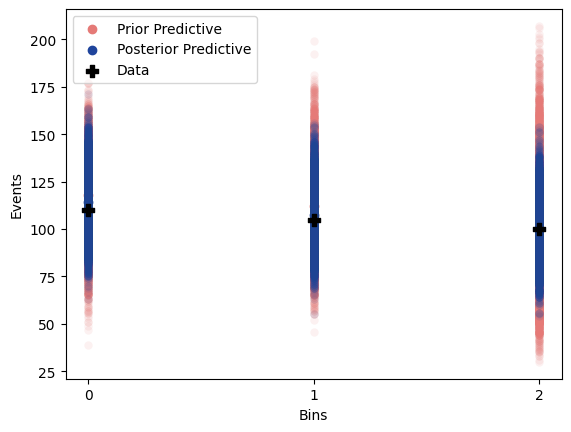

In [13]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=1)

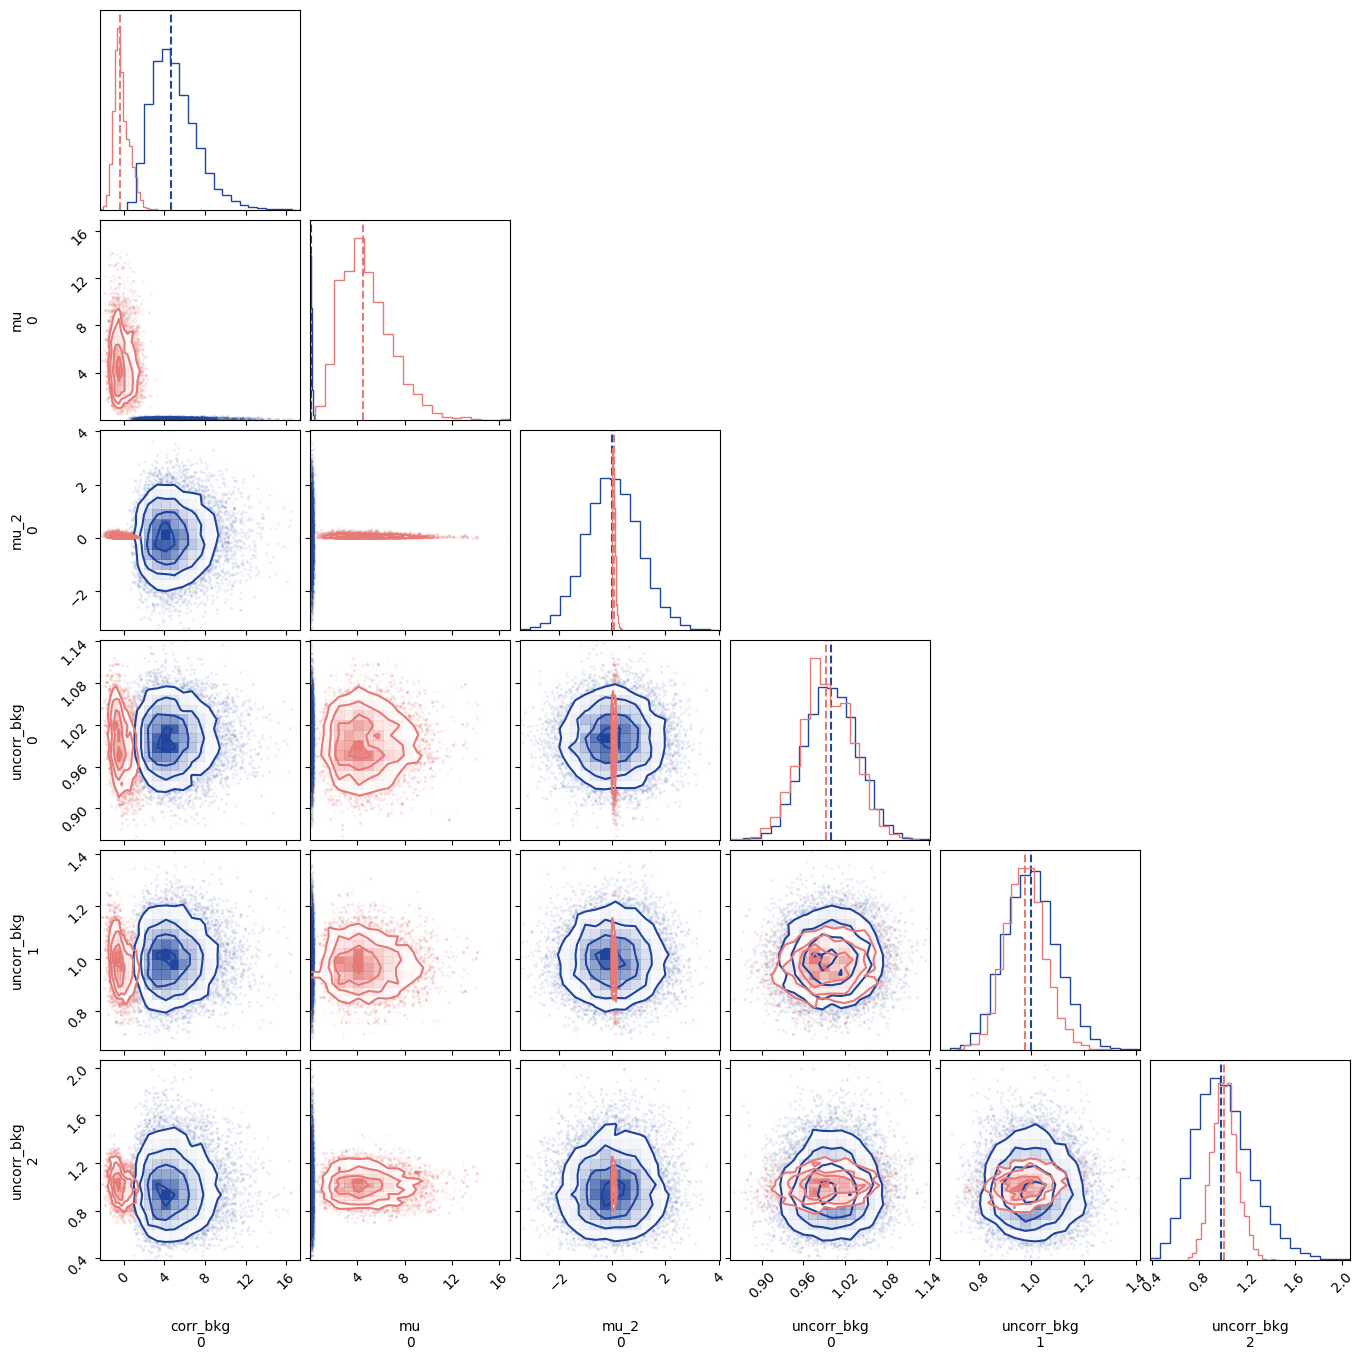

In [8]:
a = corner.corner(prior_pred.prior, quantiles=[0.5], color = blue);
corner.corner(post_data.posterior, quantiles=[0.5], color = pink, fig = a);

## Combined Inference

(2 min 23 s)
 - Additional sampling model `pm.Normal()` for the auxiliary data
 - Priors are ur-priors (with a^3 - a as alpha, beta for the Poisson constraints)

In [9]:
priorDict_combined = prepare_inference.build_priorDict_combined(model, unconstr_priors)

assert priorDict_combined.keys() == model.config.par_map.keys()

In [10]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=10_000, chains=1, step=step)
    post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    prior_pred_combined = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 5 seconds.


Sampling: [Expected_ActData, Expected_AuxData, corr_bkg, mu, mu_2, uncorr_bkg]


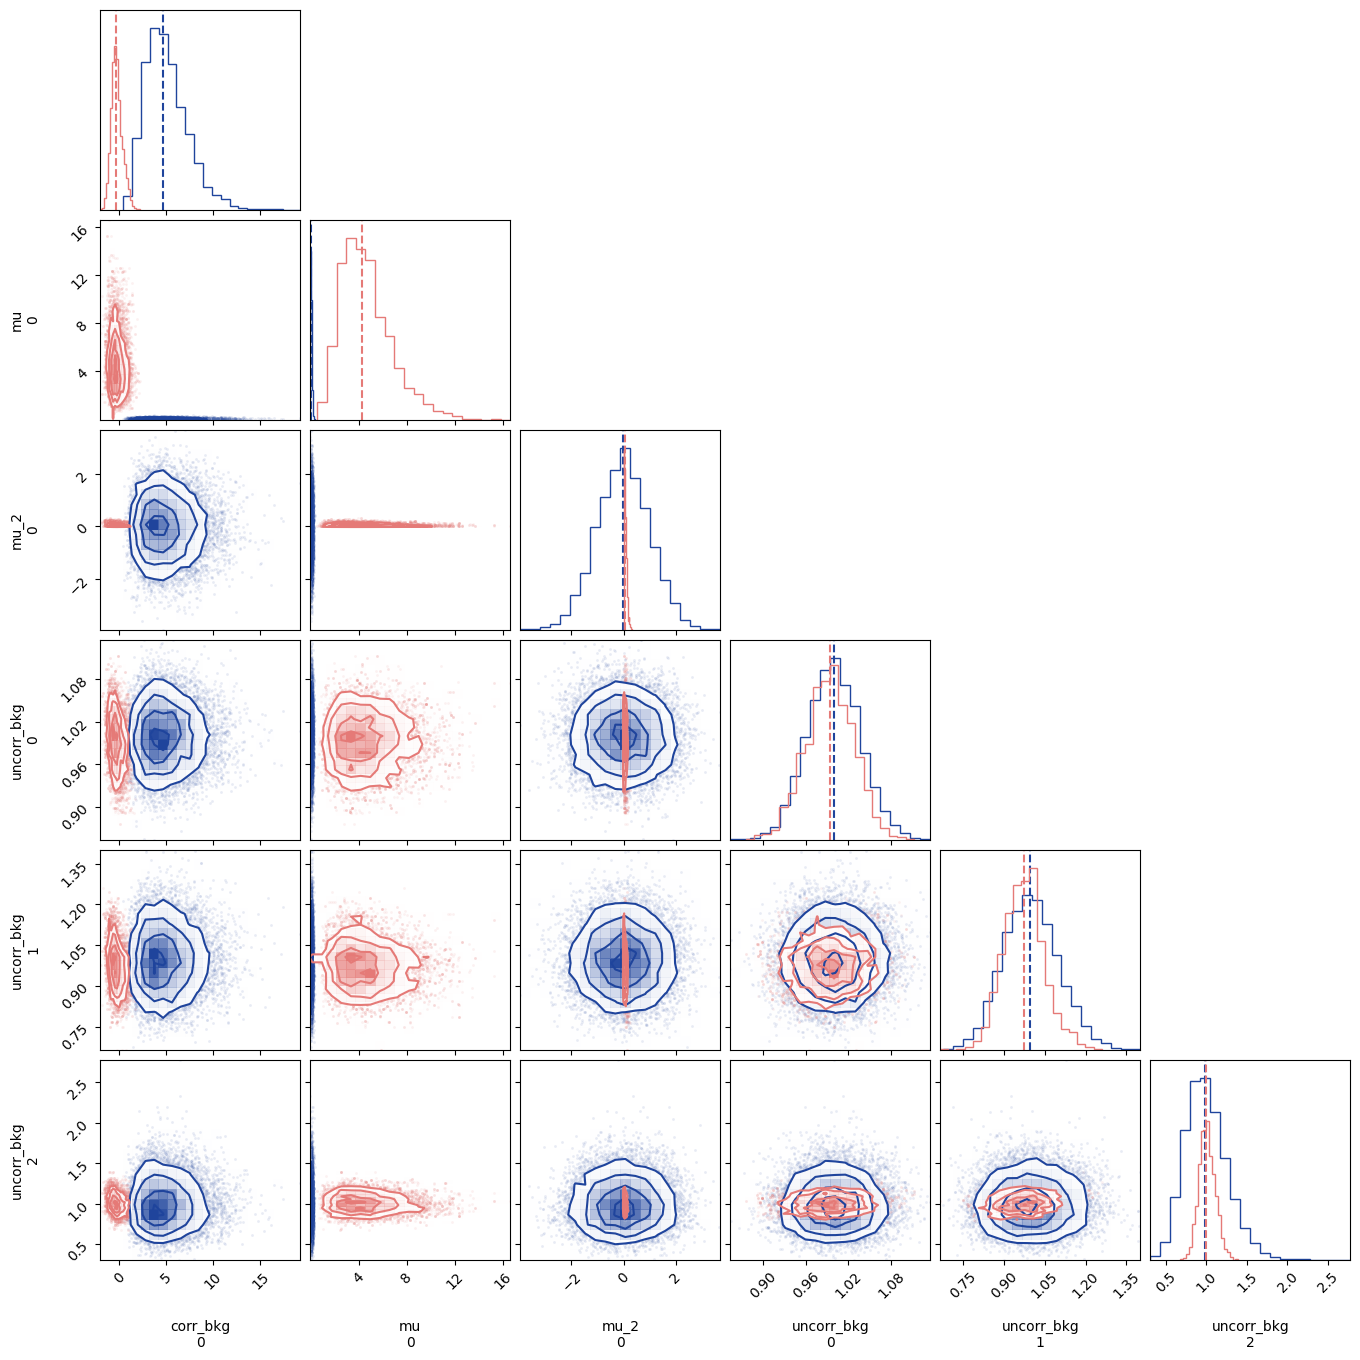

In [11]:
a = corner.corner(prior_pred_combined.prior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

### Comparing Combined / Conjugate inference

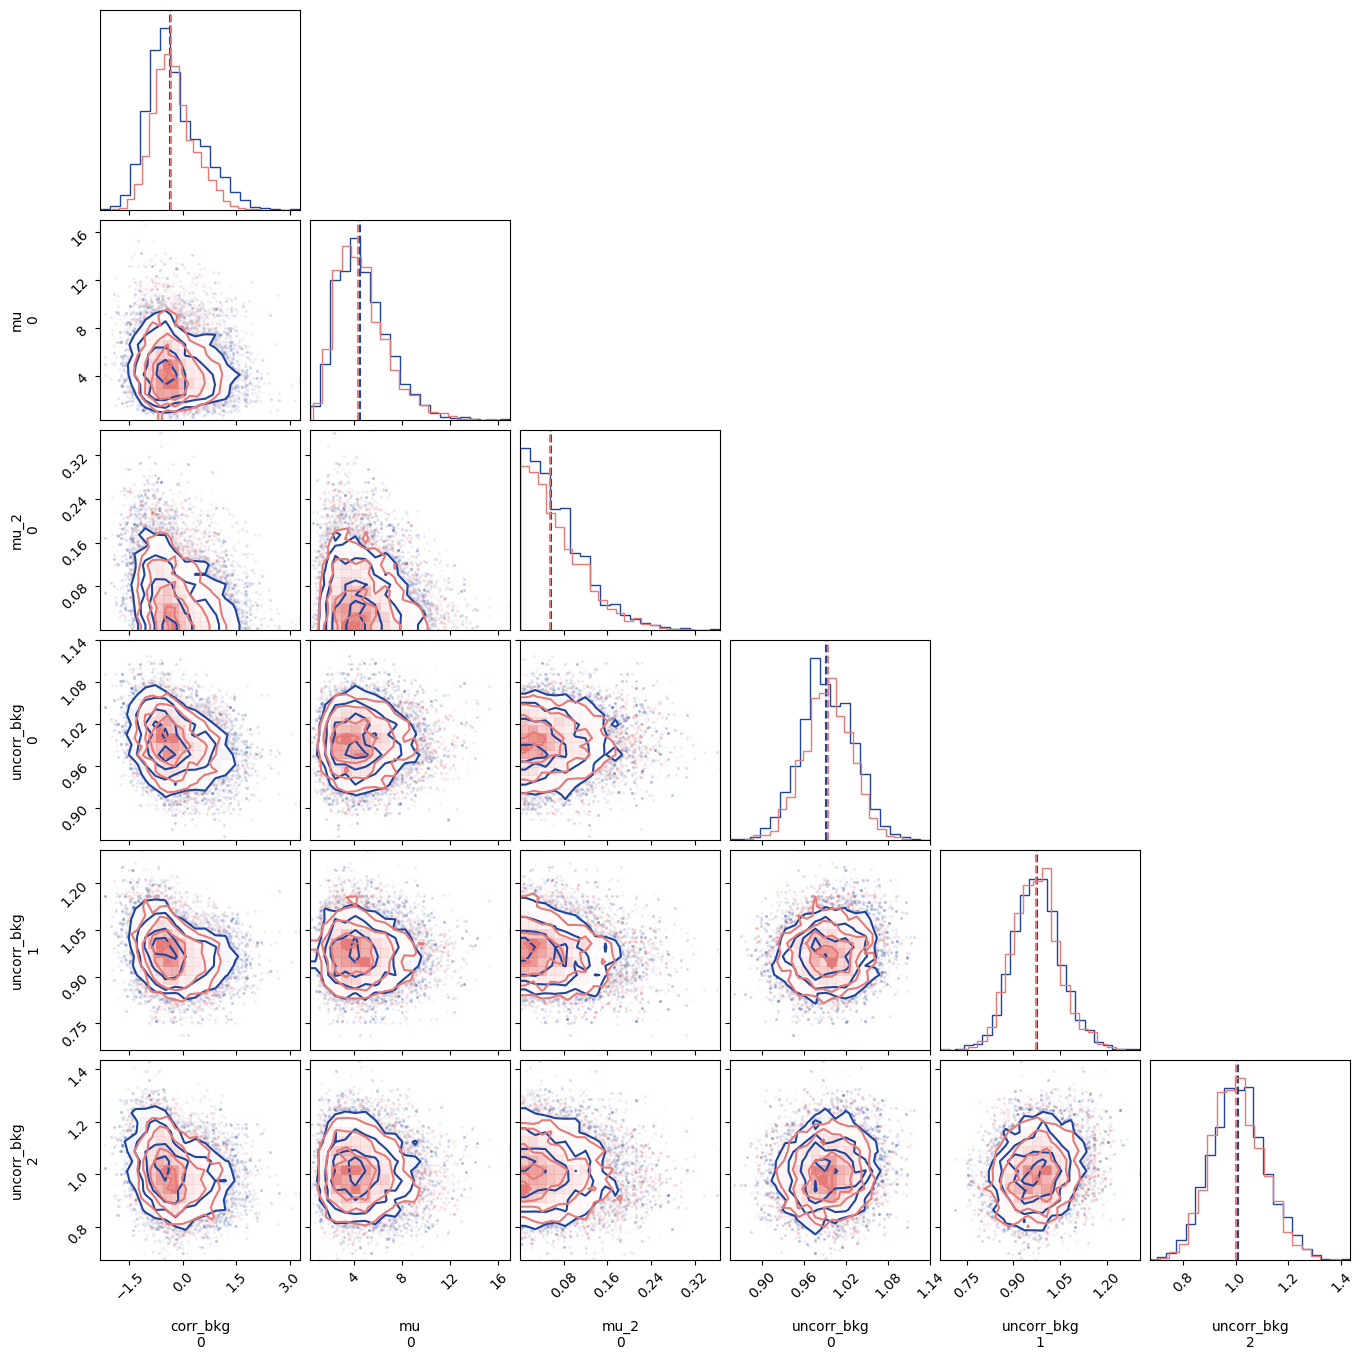

In [12]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);


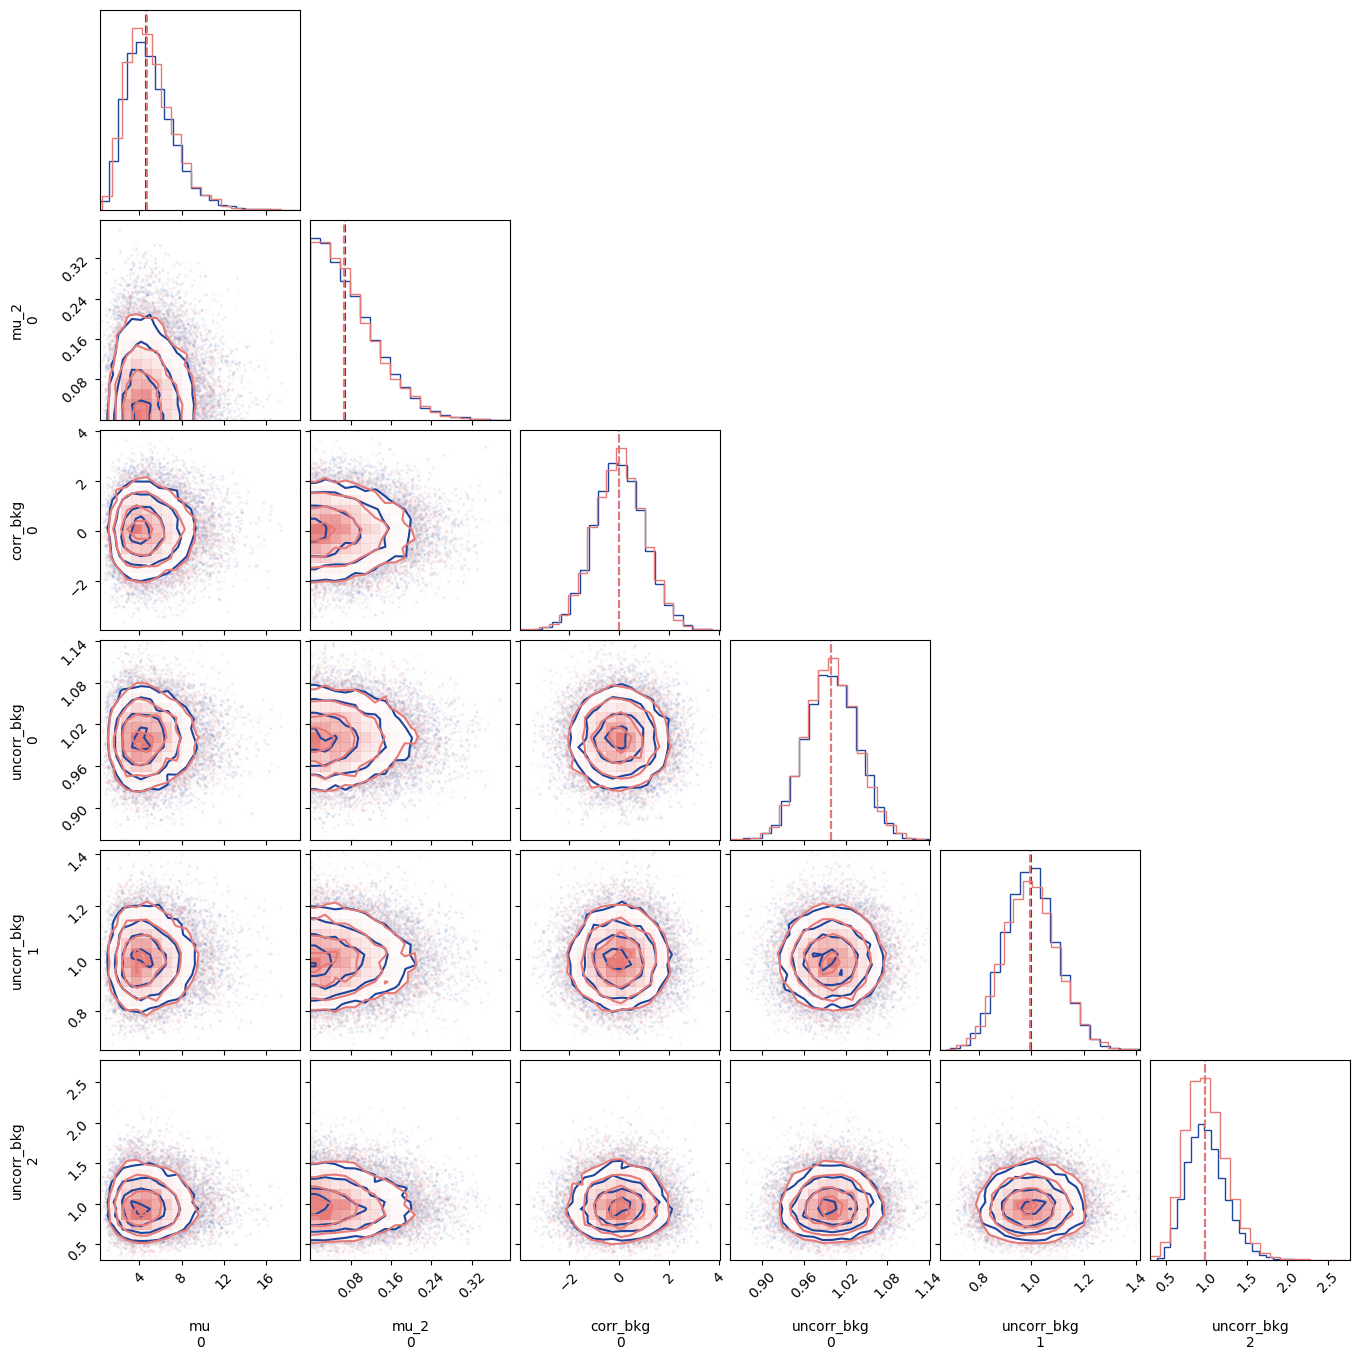

In [13]:
a = corner.corner(prior_pred.prior, quantiles=[0.5], color = blue);
corner.corner(prior_pred_combined.prior, quantiles=[0.5], color = pink, fig = a);

### Looking at Ur-Priors

In [18]:
model.config.auxdata

[0.0, 9.0, 4.652056901191849, 2.6014568158168574]

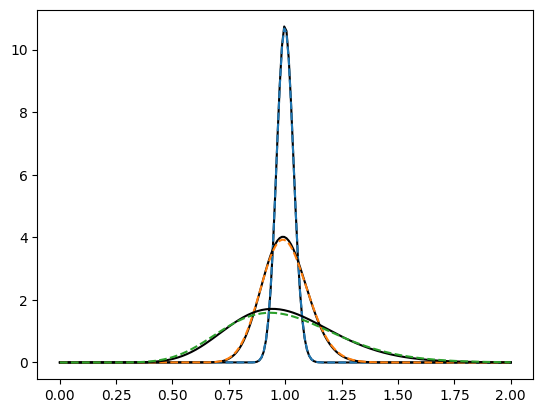

In [25]:
xx = np.linspace (0.001, 2, 200) 
for aux in [9.0, 4.652056901191849, 2.6]:
    plt.plot(xx, [sps.gamma.pdf(x, a=aux**3, scale=1/aux**3) for x in xx], c='k')
    plt.plot(xx, [sps.gamma.pdf(x, a=aux**3-aux, scale=1/(aux**3-aux)) for x in xx], '--')

## Combined Parameters for Conjugate Inference

In [15]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data1 = pm.sample(draws=10_000, chains=1, step=step)
    post_pred1 = pm.sample_posterior_predictive(post_data1)
    prior_pred1 = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 4 seconds.


Sampling: [Expected_Data, Gammas, Normals, Unconstrained_Gammas, Unconstrained_HalfNormals]


array([[<AxesSubplot: title={'center': 'corr_bkg'}>,
        <AxesSubplot: title={'center': 'corr_bkg'}>],
       [<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>],
       [<AxesSubplot: title={'center': 'mu_2'}>,
        <AxesSubplot: title={'center': 'mu_2'}>],
       [<AxesSubplot: title={'center': 'uncorr_bkg'}>,
        <AxesSubplot: title={'center': 'uncorr_bkg'}>]], dtype=object)

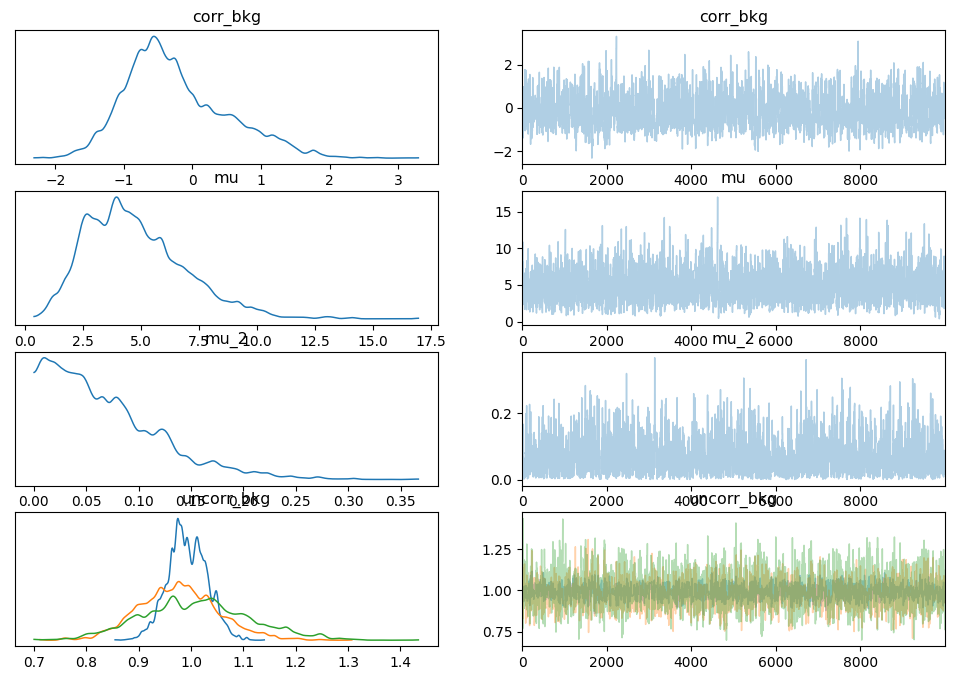

In [17]:
az.plot_trace(post_data)

array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>],
       [<AxesSubplot: title={'center': 'Gammas'}>,
        <AxesSubplot: title={'center': 'Gammas'}>],
       [<AxesSubplot: title={'center': 'Unconstrained_HalfNormals'}>,
        <AxesSubplot: title={'center': 'Unconstrained_HalfNormals'}>],
       [<AxesSubplot: title={'center': 'Unconstrained_Gammas'}>,
        <AxesSubplot: title={'center': 'Unconstrained_Gammas'}>]],
      dtype=object)

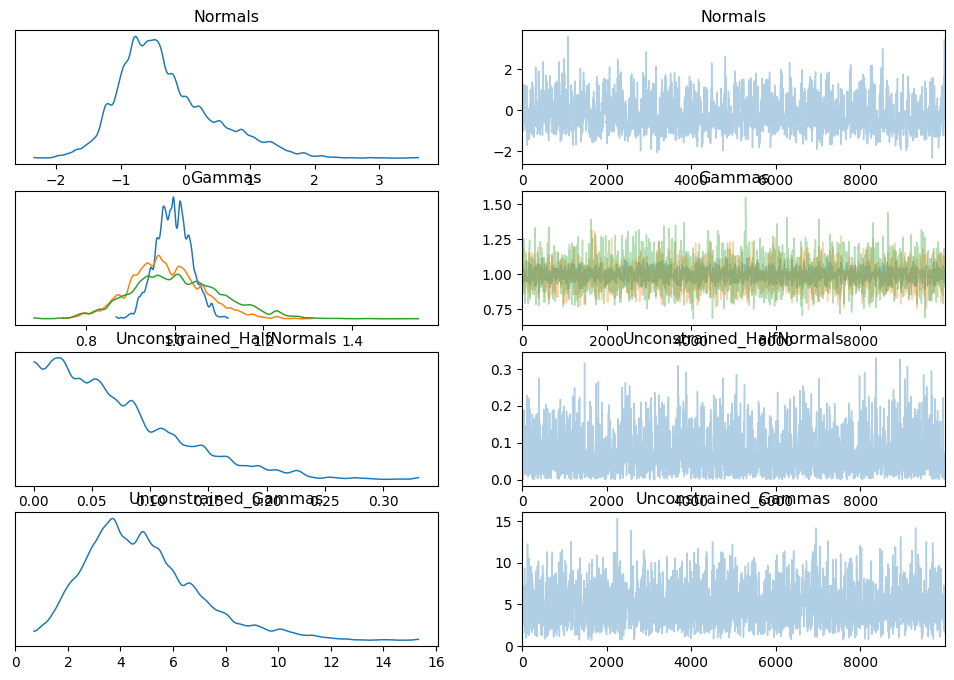

In [18]:
az.plot_trace(post_data1)

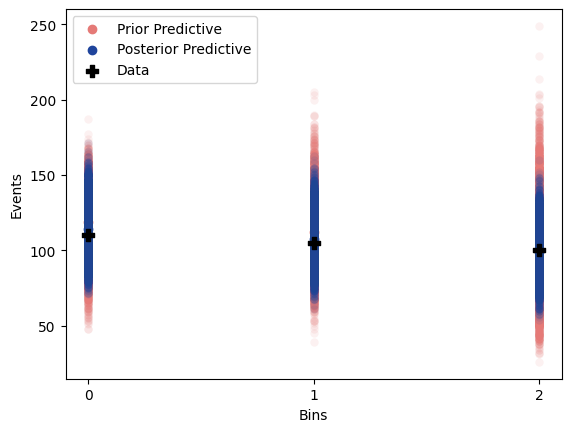

In [19]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred1, prior_pred=prior_pred1, bin_steps=1)

## Gradients

In [125]:
# Model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [10, 20, 10],
     'modifiers': [
        {'name': 'mu', 'type': 'normfactor', 'data': None}
        ]},
    {'name': 'background',
     'data': [120, 110, 130],
     'modifiers': [
        # Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
        # Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [125, 115, 220] , 'lo_data': [100, 95, 90]}},
        # Uncorrelated / Poisson
        # {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]},
         ]}]}]}
)

# Make Op
expData_op = make_op.makeOp_Act(model)

expData_op(pt.as_tensor_variable(np.ones(5))).eval()


array([135., 135., 230.])

In [126]:
len(model.config.suggested_init())

5

In [128]:
pytensor.gradient.verify_grad(expData_op, pt=(np.arange(5, dtype="float64"),), rng=np.random.default_rng())

In [119]:
expData_op.grad(inputs=(pt.as_tensor_variable(np.ones(3)),), output_gradients=(pt.as_tensor_variable(np.ones(3)),))[0].eval()

array([40.,  0.,  0.])